<div style="margin-bottom: 120px;">
    <div style="float:left;">
        <br/>
        <img src="img/udc.png" width="300"/>
    </div>
</div>

<h1 style="color: #d60e8c; text-align:center;">Clasificación supervisada</h1>

<h1>Contenidos</h1>

<div class="alert alert-block alert-info" 
     style="margin-top: 20px; padding-top:0px; padding-bottom:0px;border: 1px solid #d60e8c; border-radius: 20px; background:transparent;">
    <ol>
        <li><a href="#intro">Introducción</a></li>
        <li><a href="#about_dataset">El conjunto de datos</a></li>
        <li><a href="#visualization_analysis">Visualización de datos y análisis</a></li>
        <li><a href="#classification">Clasificación</a></li>
        <li><a href="#exercises">Ejercicios</a></li>
        <li><a href="#save_load">Guardar y cargar un modelo entrenado</a></li>
        <li><a href="#exercise_decision_trees">Ejercicios</a></li>
    </ol>
</div>

<a name="intro"></a>
# <font style="color:#d60e8c;">Introducción</font>
<hr style="border: 0.5px solid #d60e8c;">

En esta práctica aplicaremos los algoritmos para clasificación supervisada **K-Nearest Neighbors** y **SVM** sobre un mismo conjunto de datos. Y, al finalizar, realizarás una clasificación utilizando árboles de decisión.

## Importamos las librerías

Comenzamos importando las librerías que utilizaremos:

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

<a name="about_dataset"></a>
# <font style="color:#d60e8c;">El conjunto de datos </font>
<hr style="border: 0.5px solid #d60e8c;">

El conjunto de datos consiste en registros de muestras de células humanas, cada uno de los cuales contiene los valores de un conjunto de características celulares. Los campos de cada registro son:

<ul>
    <li><b>ID</b>: Identificador del paciente</li>
    <li><b>Clump</b>: Espesor</li>
    <li><b>UnifSiz</b>: Uniformidad del tamaño de las células</li>
    <li><b>Uniforme</b>: Uniformidad de la forma de la célula</li>
    <li><b>MargAdh</b>: Adhesión marginal</li>
    <li><b>SingEpiSize</b>: Tamaño de una sola célula epitelial</li>
    <li><b>BareNuc</b>: Núcleos desnudos</li>
    <li><b>BlandChrom</b>: Cromatina blanda</li>
    <li><b>NormNucl</b>: Núcleos normales</li>
    <li><b>Mit</b>: Mitosis</li>
    <li><b>Class</b>: Benigno o maligno</li>
</ul>

El campo __ID__ contiene los identificadores de los pacientes. Los campos __desde Clump hasta Mit__, son las caractererísticas de las celdas, con valores enteros con rangos desde 1 hasta 10, donde 1 es el valor más cercarno a benigno. 

El campo __Class__ contiene el diagnóstico, confirmado con procedimientos médicos e indica si las muestras son benignas (valor=2) o malignas (valor=4).

El objetivo es construir un clasificador, para predecir si una muestra desconocida es benigna o maligna. 

## Carga de datos desde un archivo CSV

In [101]:
df = pd.read_csv('cell_samples.csv', sep=";")
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


<a name="visualization_analysis"></a>
# <font style="color:#d60e8c;">Visualización y análisis de los datos </font>
<hr style="border: 0.5px solid #d60e8c;">


#### Veamos cuantos elementos tiene nuestro conjunto de datos

In [102]:
df.shape

(683, 11)

#### Veamos cuantos elementos de cada clase tenemos

In [103]:
df['Class'].value_counts()

2    444
4    239
Name: Class, dtype: int64

Veamos los atributos que caracterizan nuestro conjunto de datos:

In [104]:
df.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

## Datos de entrada y clases

Para aplicar los algoritmos de la librería <b>scikit-learn</b>, podemos convertir nuestro <b>DataFrame de Pandas</b> a dos <b>array de NumPy</b>, uno para las entradas y otro para las clases (aunque se pueden utilizar también directamente los tipos de datos de Pandas).

Seleccionamos las columnas que utilizaremos como entradas:

In [105]:
feature_df = df[df.columns[1:df.shape[1]-1]]

In [106]:
# Usando DataFrame Pandas
#X = feature_df

# Usando array NumPy
X = np.asarray(feature_df)
X[0:5] # solo para inspeccionar una muestra de X

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

Y ahora las clases:

In [107]:
# Usando DataFrame Pandas
#y = df['Class']

# Usando array NumPy
y = np.asarray(df['Class'])
y[0:5] # solo para inspeccionar una muestra de y

array([2, 2, 2, 2, 2], dtype=int64)

## División en datos de entrenamiento y prueba

La exactitud del algoritmo es el porcentaje de predicciones correctas que el modelo hace sobre datos en los que NO ha sido entrenado. 

Realizar el entrenamiento y las pruebas en el mismo conjunto de datos haría que los resultados fuesen muy buenos dentro del conjunto de pruebas pero probablemente malo fuera de ese conjunto de datos, ya que estaría "sobreajustado" a ese conjunto de datos.

<b>Es importante que nuestros modelos tengan una alta exactitud fuera de muestra, porque el propósito de cualquier modelo es hacer predicciones correctas sobre datos desconocidos</b>. Entonces, ¿cómo podemos mejorar la exactitud fuera de muestra? Una forma es utilizar un enfoque de evaluación llamado <b>división entrenamiento/pruebas</b>.

<b>La división de entrenamiento/pruebas implica la división del conjunto de datos en conjuntos de entrenamiento y pruebas respectivamente, que son mutuamente excluyentes</b>. Después de lo cual, se entrena con el conjunto de entrenamiento y se prueba con el conjunto de pruebas.

Esto proporcionará una evaluación más precisa de la exactitud de las muestras porque el conjunto de datos de prueba no forma parte del conjunto de datos que se han utilizado para entrenar los datos. Es más realista para los problemas del mundo real.

<br><br>
El siguiente código, utiliza el 80% del conjunto de datos para entrenar el modelo y el 20% para test.

In [108]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<a name="classification"></a>
# <font style="color:#d60e8c;">Clasificación</font>
<hr style="border: 0.5px solid #d60e8c;">

## Entrenamiento

### KNN

Utilizaremos el algoritmo <code>KNeighborsClassifier</code> de <b>scikit-learn</b> (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier">documentación del algoritmo</a>).



In [109]:
k = 4

# Creamos nuestra instancia del modelo
neigh = KNeighborsClassifier(n_neighbors = k)

ini = time.time() 
#Entrenamiento del modelo, llamando a su método fit 
neigh.fit(X_train,y_train)
print(f"Tiempo entrenamiento = {(time.time() - ini)*1000:.3f} ms") 

Tiempo entrenamiento = 3.988 ms


### SVM

Utilizaremos el algoritmo <code>SVC</code> de <b>scikit-learn</b> (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC">documentación del algoritmo</a>). Es el algoritmo implementado en <b>scikit-learn</b> para clasificación de <code>SVM</code>.

In [110]:
# Creamos nuestra instancia del modelo
clf_svm = svm.SVC(kernel='linear')

ini = time.time() 
#Entrenamiento del modelo, llamando a su método fit 
clf_svm.fit(X_train, y_train) 
print(f"Tiempo entrenamiento = {(time.time() - ini)*1000:.3f} ms") 

Tiempo entrenamiento = 5.982 ms


## Predicción
Ahora podemos utilizar nuestro modelo entrenado para realizar predicciones, para ello llamamos al método <code>predict</code> con el conjunto de valores que hemos reservado para test:

### k-NN

In [111]:
ini = time.time() 
y_predict_knn = neigh.predict(X_test)
print(f"Tiempo de predicción = {(time.time() - ini)*1000:.3f} ms") 

y_predict_knn[0:5] # muestra del resultado de la predicción

Tiempo de predicción = 12.965 ms


array([2, 4, 2, 4, 2], dtype=int64)

### SVM

In [112]:
ini = time.time() 
y_predict_svm = clf_svm.predict(X_test)
print(f"Tiempo de predicción = {(time.time() - ini)*1000:.3f} ms") 

y_predict_svm [0:5] # muestra del resultado de la predicción

Tiempo de predicción = 0.997 ms


array([2, 4, 2, 4, 2], dtype=int64)

## Evaluación de la predicción

Aunque trataremos en detalle la evaluación de resultados en la clase de evaluación de resultados, en esta práctica utilizaremos la función <code>score</code> incluida en los clasificadores que hemos utilizado, que devuelve la exactitud media de la predicción y mostraremos la matriz de confunsión de forma gráfica, porque nos permite ver de forma sencilla los elementos que los algoritmos han clasificado correcta e incorrectamente.

### Exactitud

In [113]:
print("Exactitud media obtenida con k-NN: ", neigh.score(X_test, y_test))

Exactitud media obtenida con k-NN:  0.9708029197080292


In [114]:
print("Exactitud media obtenida con SVM: ", clf_svm.score(X_test, y_test))

Exactitud media obtenida con SVM:  0.9635036496350365


### Matriz de confusión

Veremos con detalle las matrices de confusión en la clase de evaluación de los resultados, pero la mostramos aquí porque esta gráfica nos permite ver fácilmente el número elemetos que los algoritmos han clasificado correcta e incorrectamente. Para mostrarla utilizamos <code>ConfusionMatrixDisplay</code> (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html">documentación</a>).

<img src="img/confusion_matrix.png" style="max-width:700px;">


In [115]:
cm_kNN = confusion_matrix(y_test, y_predict_knn, labels=[2,4])


In [116]:
cm_kNN

array([[86,  4],
       [ 0, 47]], dtype=int64)

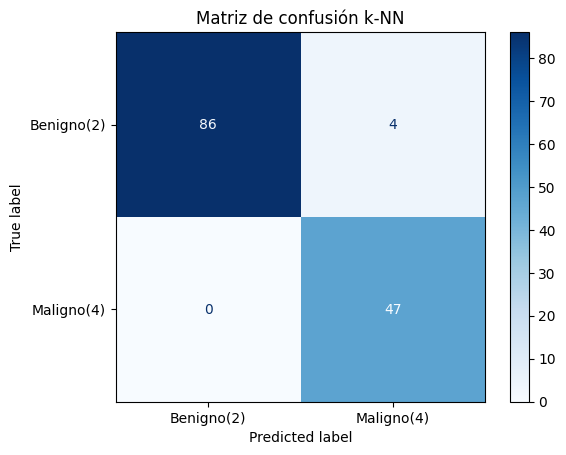

In [117]:

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_kNN, display_labels=['Benigno(2)','Maligno(4)'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión k-NN")
plt.show()

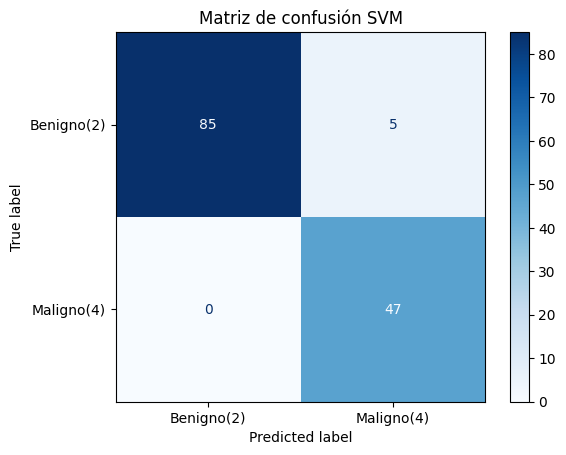

In [118]:
cm_svm = confusion_matrix(y_test, y_predict_svm, labels=[2,4])

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Benigno(2)','Maligno(4)'])
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión SVM")
plt.show()

Podemos mostrar varios gráficos en una misma figura. Para ello, vamos a utilizar la función <code>subplots</code>(<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html">documentación de la función</a>).

De esta forma, mostramos las matrices de confusión para ambos algoritmos:

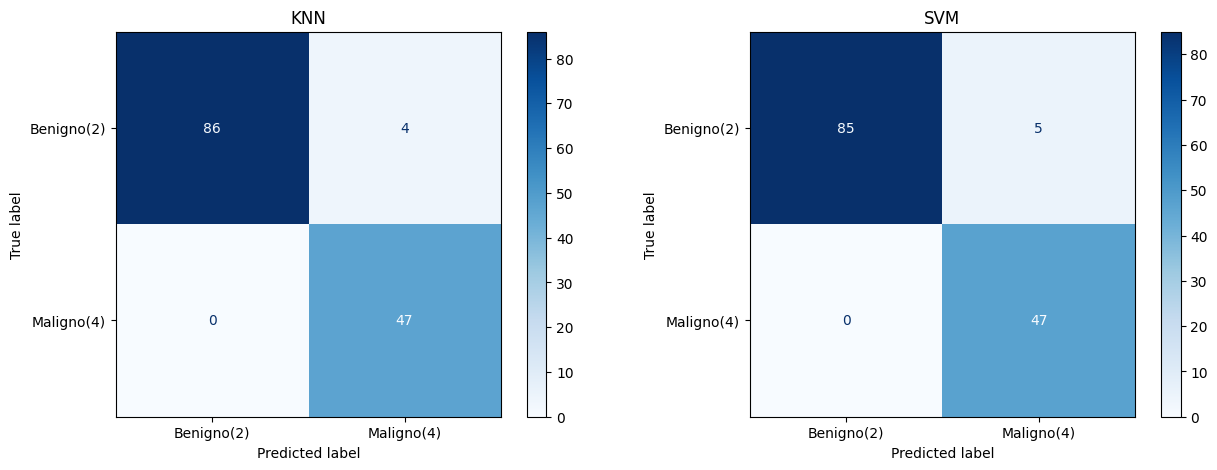

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title("KNN")
disp_knn.plot(cmap=plt.cm.Blues, ax = axs[0])
axs[1].set_title("SVM")
disp_svm.plot(cmap=plt.cm.Blues, ax = axs[1])
plt.show()

<div class="alert alert-block alert-info" 
     style="border: 0px solid #d60e8c; border-radius: 10px; background:#d60e8c; color: white; margin-top:20px;">
      <h2>EJERCICIO 1</h2>
    <hr style="border: 0.5px solid #ffffff;">
   <ul style="margin-bottom: 20px;">
       <li>Crea modelos de k-NN variando el valor de k, desde k=1 hasta k=100, calculando la exactitud de cada modelo, almacenandolos en un array numpy</li>
       <li>Muestra cual ha sido el mejor valor de k</li>
       <li>Muestra una gráfica con los valores obtenidos para cada k. <br><br>
           Ejemplo de gráfica (orientativo, los resultados pueden variar):
           <img src="img/grafica-k.png"/>
       </li>       
    </ul>
</div>

<h4>Parte1: crear los distintos modelos y calcular su exactitud.</h4>

In [120]:
# Escribe aquí tu código para realizar la primera parte del ejercicio
ini = time.time() 
exatitud = np.zeros(100)
for k in range(1,101):
    # Creamos nuestra instancia del modelo
    neigh = KNeighborsClassifier(n_neighbors = k)

    #Entrenamiento del modelo, llamando a su método fit 
    neigh.fit(X_train,y_train)
    
    exatitud[(k-1)]= neigh.score(X_test, y_test)

print(f"Tiempo entrenamiento = {(time.time() - ini)*1000:.3f} ms") 
print(exatitud) 

Tiempo entrenamiento = 1005.312 ms
[0.97810219 0.95620438 0.97080292 0.97080292 0.97080292 0.98540146
 0.98540146 0.98540146 0.97080292 0.98540146 0.97080292 0.97080292
 0.97080292 0.97810219 0.96350365 0.98540146 0.98540146 0.98540146
 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146
 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146
 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146
 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146
 0.98540146 0.98540146 0.98540146 0.98540146 0.98540146 0.97810219
 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219
 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219
 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219
 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219
 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219
 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219 0.97810219
 0.97810219 0.97810219 0.97

<h4>Parte 2: muestra el mejor valor de k.</h4>


In [121]:
# Escribe aquí tu código para realizar la segunda parte del ejercicio

print(exatitud.max())


0.9854014598540146


<h4>Parte 3:  Gráfica de la exactitud obtenida con distintos valores de k .</h4>



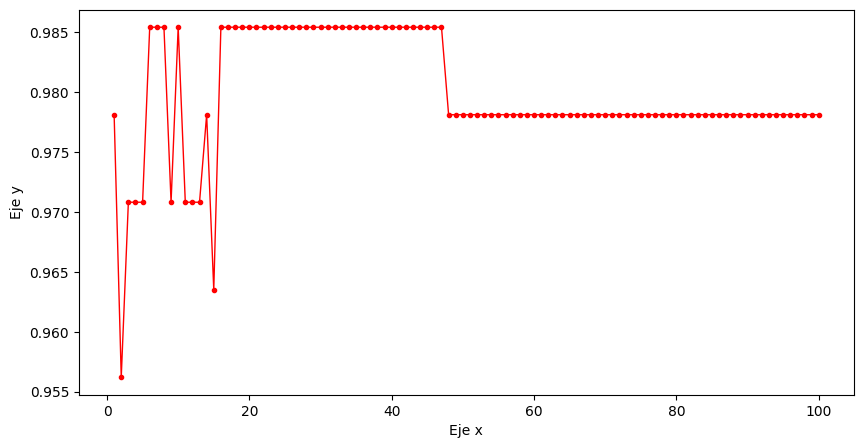

In [122]:
# Escribe aquí tu código para realizar la tercera parte del ejercicio

x_points = np.linspace(1, 100, num=100)


# Añade aquí el código necesario para mostrar la gráfica

plt.figure(figsize=(10,5))
plt.plot(x_points, exatitud, color='red', linestyle="-", linewidth=1, marker = ".")  # gráfica 1
plt.xlabel('Eje x')
plt.ylabel('Eje y')
plt.show()



<h3>SVM: Efecto de C y gamma</h3>

El parámetro gamma es el inverso de la desviación estándar del kernel RBF (función gaussiana), que se utiliza como medida de similitud entre dos puntos. Un valor gamma pequeño define una función gaussiana con una gran varianza. En este caso, dos puntos pueden considerarse similares aunque estén muy alejados el uno del otro. En cambio, un valor gamma grande significa definir una función gaussiana con una pequeña varianza y en este caso, dos puntos se consideran similares sólo si están cerca el uno del otro. 

Cuanto más estrechos sean los kernels de RBF (gammas más grandes) más "puntiagudos" serán sus hipersuperficies, es decir, tendrían una hipersuperficie cercana a cero en todas partes, excepto que tendrían picos donde están los puntos de datos. Por otro lado, si los kernels RBF son demasiado anchos (pequeños gammas), terminarías con una hipersuperficie casi plana.  

El parámetro C permite compensar la correcta clasificación de los ejemplos de formación con la maximización del margen de la función de decisión. Para valores mayores de C, se aceptará un margen menor para clasificar correctamente todos los puntos de formación. Un valor de C más bajo fomentará un margen más grande, por lo tanto una función de decisión más simple, a costa de la exatitud de la formación. En otras palabras, "C" se comporta como un parámetro de regularización en el SVM.

__El comportamiento del modelo es muy sensible al parámetro gamma__:

<ul>
    <li>Si el gamma es demasiado grande, ningún valor de C será capaz de evitar el sobreajuste.</li>
    <li>
        Si gamma es muy pequeño, el modelo no puede captar la complejidad o la "forma" de los datos. El modelo resultante se comportará de manera similar a un modelo lineal.</li>
    <li>
        Para los valores intermedios de gamma, se pueden encontrar buenos modelos. Los modelos suaves (valores gamma más bajos) pueden hacerse más complejos aumentando la importancia de clasificar cada punto correctamente (valores C más grandes).
    </li>

</ul>

<div class="alert alert-block alert-info" 
     style="border: 0px solid #d60e8c; border-radius: 10px; background:#d60e8c; color: white; margin-top:20px;">
      <h2>EJERCICIO 2</h2>
    <hr style="border: 0.5px solid #ffffff;">
   <ul style="margin-bottom: 20px;">
       <li>Crea ahora varios SVM con kernel gausiano ('rbf') variando el valor de C y de gamma (al menos 4 valores de cada uno), entrenando y calculando la exactitud de cada combinación de C y gamma.</li>
       <li>¿Qué valores de C y gamma han obtenido el mejor resultado? </li>
    </ul>
</div>

In [123]:
## Pon aquí tu código para realizar el ejercicio 2
valores = 5
valorc = np.linspace(0.01, 2, num = valores)
valorg = np.linspace(0.01, 2, num = valores)
exatitudsvm = np.array([np.zeros(valores * valores), np.zeros(valores * valores),np.zeros(valores * valores)])
k=0

for i in valorc:
    for j in valorg:
        # Creamos nuestra instancia del modelo
        clf_svm = svm.SVC(kernel='rbf',C=i,gamma=j)

        ini = time.time() 

        #Entrenamiento del modelo, llamando a su método fit 
        clf_svm.fit(X_train, y_train) 
        k=k+1

        #Exactitud 
        exatitudsvm [0] [(k-1)] = clf_svm.score(X_test, y_test)
        exatitudsvm [1] [(k-1)] = i
        exatitudsvm [2] [(k-1)] = j
        
        
print("Exactitudes:")
print(exatitudsvm)

max = exatitudsvm[0].max()
print("Exactitud maxima: ", max)

k=0

for i in valorc:
    for j in valorg:
        if exatitudsvm [0] [(k-1)] == max:
            print("Valor C: ", exatitudsvm [1] [(k-1)])
            print("Valor g: ", exatitudsvm [2] [(k-1)])
        k=k+1

Exactitudes:
[[0.97080292 0.65693431 0.65693431 0.65693431 0.65693431 0.96350365
  0.88321168 0.83211679 0.78832117 0.82481752 0.96350365 0.91240876
  0.87591241 0.86131387 0.83211679 0.96350365 0.91240876 0.88321168
  0.86861314 0.86861314 0.96350365 0.91240876 0.88321168 0.86861314
  0.86861314]
 [0.01       0.01       0.01       0.01       0.01       0.5075
  0.5075     0.5075     0.5075     0.5075     1.005      1.005
  1.005      1.005      1.005      1.5025     1.5025     1.5025
  1.5025     1.5025     2.         2.         2.         2.
  2.        ]
 [0.01       0.5075     1.005      1.5025     2.         0.01
  0.5075     1.005      1.5025     2.         0.01       0.5075
  1.005      1.5025     2.         0.01       0.5075     1.005
  1.5025     2.         0.01       0.5075     1.005      1.5025
  2.        ]]
Exactitud maxima:  0.9708029197080292
Valor C:  0.01
Valor g:  0.01


<a name="save_load"></a>
# <font style="color:#d60e8c;">Guardar y cargar un modelo</font>
<hr style="border: 0.5px solid #d60e8c;">

Podemos guardar un modelo entrenado para usarlo para hacer predicciones.

El siguiente bloque de código, entrena un modelo <code>SVM</code> y lo guarda en un fichero.


In [124]:
from joblib import dump, load

clf_to_save = svm.SVC(kernel='rbf', gamma=0.1)
clf_to_save.fit(X_train, y_train)
print("Exactitud del modelo: ", clf_to_save.score(X_test,y_test))

dump(clf_to_save, 'svm_cell_samples.joblib') 

Exactitud del modelo:  0.9635036496350365


['svm_cell_samples.joblib']

<br/>
En siguiente bloque de código, carga el modelo guardado previamente y lo utiliza para realizar predicciones:

In [125]:
clf_loaded = load('svm_cell_samples.joblib') 

clf_loaded.predict(X_test[0:5]) # Predicción de los cinco primeros valores del conjunto de datos de test

array([2, 4, 2, 4, 2], dtype=int64)

<div class="alert alert-block alert-info" 
     style="border: 0px solid #d60e8c; border-radius: 10px; background:#d60e8c; color: white; margin-top:20px;">
      <h2>EJERCICIO 3</h2>
    <hr style="border: 0.5px solid #ffffff;">
    Utiliza ahora el algoritmo <b>DecisionTreeClassifier</b> de <b>scikit-learn</b> (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">documentación del algoritmo</a>) sobre el mismo conjunto de datos:
   <ul style="margin-bottom: 20px;">
       <li>Configura el modelo con los parámetros que consideres</li>       
       <li>Entrénalo y guarda en un archivo el modelo entrenado</li>       
       <li>Muestra una figura con el arbol generado</li>       
       <li>Calcula y muestra la exactitud del modelo (score)</li>
       <li>Carga el modelo guardado y utilízalo para realizar la predicción sobre los 5 primeros registros del conjunto de datos de test</li>
    </ul>
</div>

In [ ]:
## Pon aquí tu código para realizar el ejercicio 3 - puedes crear celdas adidionales si lo necesitas
from sklearn import tree

# Creamos nuestra instancia del modelo
modelo_tree = tree.DecisionTreeClassifier()

#Entrenamiento del modelo, llamando a su método fit 
modelo_tree.fit(X_train, y_train)

#Guarda el modelo  entrenado en un archivo
dump(modelo_tree, 'modelo_tree_guardado.joblib')


['modelo_tree_guardado.joblib']

[Text(0.42418032786885246, 0.9545454545454546, 'x[1] <= 2.5\ngini = 0.456\nsamples = 546\nvalue = [354, 192]'),
 Text(0.2459016393442623, 0.8636363636363636, 'x[5] <= 5.5\ngini = 0.069\nsamples = 337\nvalue = [325, 12]'),
 Text(0.16393442622950818, 0.7727272727272727, 'x[0] <= 6.5\ngini = 0.03\nsamples = 329\nvalue = [324, 5]'),
 Text(0.09836065573770492, 0.6818181818181818, 'x[7] <= 9.0\ngini = 0.012\nsamples = 324\nvalue = [322, 2]'),
 Text(0.06557377049180328, 0.5909090909090909, 'x[5] <= 4.5\ngini = 0.006\nsamples = 323\nvalue = [322, 1]'),
 Text(0.03278688524590164, 0.5, 'gini = 0.0\nsamples = 317\nvalue = [317, 0]'),
 Text(0.09836065573770492, 0.5, 'x[3] <= 2.0\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.06557377049180328, 0.4090909090909091, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.13114754098360656, 0.4090909090909091, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.13114754098360656, 0.5909090909090909, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text

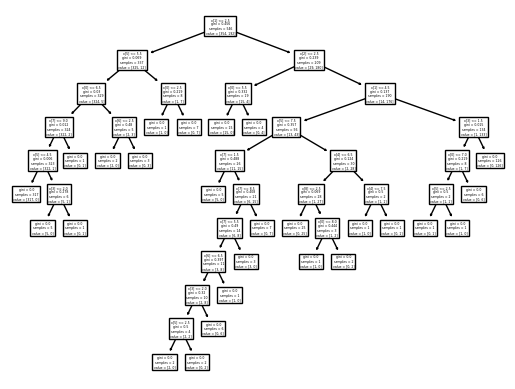

In [ ]:

tree.plot_tree(modelo_tree)



In [ ]:
modelo_tree_loaded = load('modelo_tree_guardado.joblib') 
modelo_tree_loaded.
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión k-NN")
plt.show()

modelo_tree.get_params()
modelo_tree.kneighbors_graph()
modelo_tree.
plt.title("Matriz de confusión k-NN")
plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_path'

In [133]:
modelo_tree_loaded = load('modelo_tree_guardado.joblib') 

modelo_tree_loaded.predict(X_test[0:5]) # Predicción de los cinco primeros valores del conjunto de datos de test

array([2, 4, 2, 4, 2], dtype=int64)

<br/><br/>
<hr style="border: 0.5px solid #d60e8c;">
<div style="text-align:right;">
MASTER UNIVERSITARIO EN INGENIERÍA INDUSTRIAL
</div>